<a id='executive'></a>
# Collaborative Filtering Recommender using Products, Customers and Ratings from Amazon Customer Reviews


-----------
## Executive Summary

Amazon is a multinational technology company based in Seattle, Washington, that focuses on e-commerce, cloud computing, digital streaming, artificial intelligence and more.  One of its most popular services is the e-commerce website ‘Amazon.com.’  One of the ways Amazon keeps its shoppers engaged is by way of its product recommendation system. The product recommendation system uses content and collaborative based filtering, looking at a shopper’s past purchases and purchases by shoppers who purchased similar items and then recommends items that the shopper may like based off of these two behaviors. Collaborative filtering enables the shopper to see items from other categories, while content based filtering allows shoppers to see domain specific items.

Unlike content based filtering, which suggest only similar products or domain specific products, collaborative filtering recommendation systems allows users to find similar products and jump (or switch) to other categories of products based on similarities with other users and products.  In this case, we explore 3 different ways to use collaborative based filtering.

1. The first method suggests products that other users like to a specific user based on their rating of a specific product.  Essentially, it finds users that rated a product similar to the specific user and returns the top products the other users liked.


2. The second method predicts what products a user may like based on past rating history and the rating history of other users.  This method is not specific to the rating of one product like the first method.


3. The third method predicts products similar to a specific product by finding the nearest neighbors to that product.  This method is good for users who may want to purchase products as bundles.


We evaluate our methods by:
- Testing the recommendation systems to see what products they return.
- Understanding matrix factorization and how it effects collaborative filtering systems.
- Selecting and tuning various recommendation algorithms to find the best performing algorithm.
- Understanding estimated ratings vs. true ratings.
- Performing precision@k and recall@k tests.

The dataset that is used has 5,813,109 total reviews/ratings from 3,649,861 unique customers that review 11,502 unique products that are in the categories of automotive, digital music, toys, music, cameras, video dvd, tools, digital ebook, baby, musical instruments, books, watches, digital video download, video, mobile apps, outdoors, home imporvement, PC, video games, lawn & garden, sports, electronics, wireless, home entertainment, kitchen, office products, home, health & personal care and shoes.

<a id='Table of Contents'></a>

-----
## Table of Contents 

### <a href='#executive'>Executive Summary</a>

----

### <a href='#import'>Import & Prepare Data</a>

----

### <a href='#simple'>Simple Collaborative Filtering Recommendation System</a>

- <a href='#steps'>Building the Steps</a>

- <a href='#test1'>Test 1 - Speed vs. Referencing</a>

- <a href='#test2'>Test 2 - Highly Purchased Products</a>

- <a href='#test3'>Test 3 - Low Purchased Products</a>

----

### <a href='#understanding'>Understanding Pivoting, Matrix Factorization and Aggregation</a>

- <a href='#visualizing'>Visualizing a Matrix</a>

- <a href='#example'>Example Matrix</a>

----

### <a href='#surprise'>Surprise</a>

----

### <a href='#sampling'>Sampling the Dataset</a>

----

### <a href='#selecting'>Selecting and Tuning an Algorithm</a>

- <a href='#algorithm'>Algotrithm Selection</a>

- <a href='#hyperparameter'>Hyperparameter Tuning</a>

- <a href='#testing'>Testing Tuned Algorithm vs. Default Algorithm</a>

----

### <a href='#predicting'>Predicting Customer Star Ratings for a Product</a>

----

### <a href='#recommending'>Recommending Products to a Customer</a>

- <a href='#building'>Building the Recommender</a>

- <a href='#testing2'>Testing Product Recommendations for Customers</a>

- <a href='#test_1'>Test 1 - Several Previous Ratings + With or Without Estimated Ratings Attached</a>

- <a href='#test_2'>Test 2 - One Previous Rating</a>

- <a href='#test_3'>Test 3 - Multiple Previous Ratings</a>

----

### <a href='#evaluating'>Evaluating Product Recommendations for a Customer</a>

----

### <a href='#similar'>Recommending Similar Products</a>

- <a href='#test__1'>Test 1 - Minecraft</a>

- <a href='#test__2'>Test 2 - Candy Crush Saga</a>

- <a href='#test__3'>Test 3 - Game of Thrones Season 1</a>

- <a href='#test__4'>Test 4 - Ted (Unrated)</a>

- <a href='#test__5'>Test 5 - Google Chromecast HDMI Streaming Media Player</a>

- <a href='#test__6'>Test 6 - Lego Ghostbusters Ecto-1 21108</a>

---

### <a href='#conclusion'>Conclusion</a>

---

### <a href='#potential'>Potential Future Work</a>

 <a id='import'></a>
 <a href='#Table of Contents'>Table of Contents</a>
 
 -----------
## Import & Prepare Data


We start by importing all of the modules, libraries and packages needed to begin analysis for our recommendation systems.  We will also drop all duplicated customer/product reviews (20761) and sort our dataset by customer id for easier indexing.  We will then set our dataset up for a simple collaborative filtering recommendation system.

In [1]:
%matplotlib inline
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict, Counter

from surprise import Reader, Dataset, accuracy
from surprise import SVD, SVDpp, NMF, SlopeOne, NormalPredictor, KNNBaseline, KNNBasic
from surprise import KNNWithMeans, BaselineOnly, CoClustering

from surprise.model_selection import GridSearchCV, KFold
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate

In [2]:
# Read in data
apr = pd.read_csv('APR_data/apr.csv')
apr.drop('Unnamed: 0', axis=1, inplace=True)

# Check for duplicated reviews
duplicated = apr[apr.duplicated(['customer_id', 'product_id'], keep=False)]

# Display duplicated
print('Number of duplications: {}'.format(duplicated.shape[0]))
pd.concat([apr[apr.duplicated(['customer_id', 'product_id'], keep=False)].head(2),
           apr[apr.duplicated(['customer_id', 'product_id'], keep=False)].tail(4)]
         )

Number of duplications: 20761


,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,downvotes,total_votes,verified_purchase,review_headline,review_body,review_date,purchased_counts
16,48145149,R2UT2YCJ1GBHC6,1563890119,763187671,The Sandman Vol. 1: Preludes and Nocturnes,Books,5.0,1.0,2.0,3.0,N,"Oh come on people, four stars?",This introduction to the greatest graphic nove...,2001-04-30,137
17,48145149,R14L493O2SFWSP,1563890119,763187671,The Sandman Vol. 1: Preludes and Nocturnes,Books,5.0,0.0,2.0,2.0,N,"Oh come on people, four stars?",This introduction to the greatest graphic nove...,2001-04-30,137
5793935,20737814,R11K8F0EPST8AP,B00VRYCGLO,183194229,Mahjong Journey®,Mobile Apps,4.0,0.0,0.0,0.0,Y,Manning journey,"This game has smaller than usual tiles, which ...",2015-05-29,4679
5793937,20737814,R17BCBKI22FRDK,B00VRYCGLO,183194229,Mahjong Journey®,Mobile Apps,4.0,0.0,0.0,0.0,Y,Manning journey,"This game has smaller than usual tiles, which ...",2015-05-29,4679
5794615,25991980,RT4W1XPENOBYY,B00VRYCGLO,183194229,Mahjong Journey®,Mobile Apps,5.0,0.0,0.0,0.0,Y,Great version of Mahjong,I like this Mahjong better than he other 3 I h...,2015-06-06,4679
5794616,25991980,R3K6SZ04OJ9E62,B00VRYCGLO,183194229,Mahjong Journey®,Mobile Apps,5.0,0.0,0.0,0.0,Y,Great version of Mahjong,I like this Mahjong better than he other 3 I h...,2015-06-06,4679


In [3]:
# Drop duplicates
apr = apr[~apr.duplicated(['customer_id', 'product_id'], keep=False)].reset_index().drop('index', axis=1)

# Sort apr by customer_id and reset index
apr = apr.set_index('customer_id').sort_values('customer_id')
apr = apr.reset_index()

apr.head()

,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,downvotes,total_votes,verified_purchase,review_headline,review_body,review_date,purchased_counts
0,10001,R355MHM0X7RJ1V,B007SPPANM,764225016,Titanic,Video DVD,5.0,1.0,1.0,2.0,N,Best movie,best movie of all time!!!!!!!! Leonardo is ama...,2012-10-20,230
1,10001,R1O7YFSVGERAL5,B000FBFN1U,549456361,"A Storm of Swords (A Song of Ice and Fire, Boo...",Digital eBook Purchase,5.0,0.0,0.0,0.0,Y,Great read,Remarkable storytelling! Off to start next boo...,2012-12-31,2224
2,10018,R2LQC6HFQIOETX,B007R11DKQ,855352034,Stardust,Digital Video Download,4.0,0.0,0.0,0.0,N,South City Review,"Great Movie, Enjoyed every minute. Big fun of ...",2014-04-09,1270
3,10020,R19QPW7C4I7BOM,B004T0E2S8,614617161,Ultimate Guitar Tabs,Mobile Apps,5.0,0.0,0.0,0.0,Y,this app is AWESOME!!!,On the go without an Internet connection??? Do...,2014-07-26,246
4,10022,R36JURELK6GBA7,B00KNWYDU8,779873629,Dragon City,Mobile Apps,5.0,0.0,0.0,0.0,Y,awesome,This game Occupies me all the time I love it,2015-08-27,4840


<a id='simple'></a>
<a href='#Table of Contents'>Table of Contents</a>

-----------
## Simple Collaborative Filtering Recommendation System


The purpose of this simple collaborative filtering recommendation system is to show the inner workings behind a basic recommendation system.  This recommendation system works behind the notion of:

“If you know my previous habits, you’re assuming I’m going to stay that way for the rest of my life. You’re trying to channel me into buying a product. I want to experience this world by stepping where I’ve never stepped before and buying something I never thought of buying.”

The idea is to recommend items to a customer that the customer may have not thought of purchasing before. A refined way of browsing through products and not being hindered to a set of similar products.  This recommendation system recommends products to a customer based off of the rating that they gave a certain product.  It filters through all other customers who have rated the product the same way and gives the most popular items purchased by these customers, essentially recommending products liked by similar customers.

The datasets referenced have different minimum purchase counts per user (thresholds), which effect the speed and accuracy of the recommendation system.  The higher the threshold, the faster the recommendation.  The lower the threshold, the more similar users compared.

Thresholds:
- APR is all users from one purchase and up.
- Multiple is all users from two purchases and up.
- Many is all users from three purchases and up. 
- Several is all user from three purchases and up.  

The changes in thresholds are due to the size of the datasets, unique customers and unique products.

In [4]:
# Count how many times a customer purchased a product
counts = apr['customer_id'].value_counts()

# Apply count filtering
multiple = apr[apr['customer_id'].isin(counts.index[counts>1])].reset_index().drop('index', axis=1)
several = apr[apr['customer_id'].isin(counts.index[counts>2])].reset_index().drop('index', axis=1)
many = apr[apr['customer_id'].isin(counts.index[counts>3])].reset_index().drop('index', axis=1)

# APR
print('Size of apr: {:,}'.format(len(apr)))
print('Unique apr customers: {:,}'.format(len(apr.customer_id.unique())))
print('Unique apr products: {:,}'.format(len(apr.product_id.unique())))
print('\n')

# Multiple
print('Size of multiple: {:,}'.format(len(multiple)))
print('Unique multiple customers: {:,}'.format(len(multiple.customer_id.unique())))
print('Unique multiple products: {:,}'.format(len(multiple.product_id.unique())))
print('\n')

# Several
print('Size of several: {:,}'.format(len(several)))
print('Unique several customers: {:,}'.format(len(several.customer_id.unique())))
print('Unique several products: {:,}'.format(len(several.product_id.unique())))
print('\n')

# Many
print('Size of many: {:,}'.format(len(many)))
print('Unique many customers: {:,}'.format(len(many.customer_id.unique())))
print('Unique many products: {:,}'.format(len(many.product_id.unique())))

Size of apr: 5,813,109
Unique apr customers: 3,649,861
Unique apr products: 11,502


Size of multiple: 3,091,744
Unique multiple customers: 928,496
Unique multiple products: 11,502


Size of several: 2,025,112
Unique several customers: 395,180
Unique several products: 11,502


Size of many: 1,470,094
Unique many customers: 210,174
Unique many products: 11,502


<a id='steps'></a>


**The simple collaborative filtering recommendation system does the following steps to recommend products to a customer:**

1. Takes in a dataset, user and product.
2. Filters to all other users that have purchased the same product as the original user.
3. Filters to all users that gave the same rating as the original user.
4. Filters to all products those users purchased.
5. Filters to 5 star products those users purchased.
6. Takes the top 10 (or most common) products those users gave 5 stars.
7. Returns the products.

This recommendation will tell a user what other users like them like.  Recommendations are user/product specific.  Recommended products are not necessarily similar.

***This is not a prediction model, this algorithm was created to give the reader an understanding of how a recommendation system works.***

<a href='#Table of Contents'>Table of Contents</a>

In [5]:
def collab(dataset, customer_id, product_id):
    '''This is a basic collaborative recommendation system that:
    
    1. Takes in a dataset, user and product.
    2. Filters to all other users that have purchased the same product as the original user.
    3. Filters to all users that gave the same rating as the original user.
    4. Filters to all products those users purchased.
    5. Filters to 5 star products those users purchased.
    6. Takes the top 10 (or most common) products those users gave 5 stars.
    7. Returns the products.
    
    This recommendation will tell a user what other users like them like.
    Products are not necessarily similar
    '''
    
    # Filter out original customer and retrieve only customers that purchased the same product
    user_condition = dataset.customer_id != customer_id # Not original customer
    product_condition = dataset.product_id == product_id # Is product
    ratings_by_others = dataset[user_condition & product_condition] # Other customers who purchased product
    if ratings_by_others.empty: # All products have at least 100 ratings
        return 'no matches'

    # Retrieve initial customer's rating
    user_rating = dataset[(dataset.customer_id == customer_id) & (dataset.product_id == product_id)].star_rating
    
    # Find only other customers that rated that product the same rating
    # If the customer gave the product a 2, it would find other customers that gave the product a 2, so on
    similar_user_ratings = ratings_by_others[user_rating.iloc[0] == ratings_by_others.star_rating]
    
    # Extract customer id of like-minded customers (same ratings as selected customer)
    similar_users = similar_user_ratings.customer_id
    
    # Retrieve all the like-minded customers' purchased products and ratings
    similar_user_products = dataset.loc[dataset.customer_id.isin(similar_users)]
    
    # Filter only the 5 star products of these customers
    five_star_products = similar_user_products[similar_user_products.star_rating == 5.0]

    # Sort 5 star products by how many other customers purchased that product
    top_products = five_star_products.product_id.value_counts().sort_values(ascending=False).index
    
    # Filter top 10 5 star products selected by customers who purchased the original customer's product
    top_10 = dataset.loc[dataset.product_id.isin(top_products[:10])].product_title.unique()
    print('---------------------------------------')
    print('{} other customers purchased this product.'.format(len(similar_users)))
    print('Similar customers purchased {} other products.'.format(len(five_star_products)))
    print('\nWe recommend these products from those similar customers:')
    for integer, product in enumerate(top_10):
        print(integer,' ', product)
    print('\n')

<a id='test1'></a>
<a href='#Table of Contents'>Table of Contents</a>

### Test 1
The first test observes the time it takes the recommendation system to go through each threshold.  We observe that as the threshold goes up, the speed of the recommendation system gets faster, but there are less unique customers and total products to reference.  Because of the changes, we can see differences in recommendations from threshold to threshold.

In [6]:
# Find specific customer and product
apr[apr.product_id == 'B00AREIAI8'][
    ['customer_id', 'product_id', 'product_title', 'product_category', 
     'star_rating', 'review_headline', 'purchased_counts']
].head(1)

,customer_id,product_id,product_title,product_category,star_rating,review_headline,purchased_counts
29,10285,B00AREIAI8,My Horse,Mobile Apps,5.0,Great game!,26826


In [7]:
%%time

# Threshold: 1 or more purchases per customer
collab(apr, 10285, 'B00AREIAI8')

---------------------------------------
19124 other customers purchased this product.
Similar customers purchased 29287 other products.

We recommend these products from those similar customers:
0   Minecraft
1   Flappy Wings (not Flappy Bird)
2   Candy Crush Saga
3   Crossy Road
4   My Horse
5   Subway Surfers
6   Minion Rush: Despicable Me Official Game
7   Guess The Emoji
8   Temple Run 2
9   Temple Run


CPU times: user 1.94 s, sys: 161 ms, total: 2.1 s
Wall time: 1.58 s


In [8]:
%%time

# Threshold: 2 or more purchases per customer
collab(multiple, 10285, 'B00AREIAI8')

---------------------------------------
6734 other customers purchased this product.
Similar customers purchased 16897 other products.

We recommend these products from those similar customers:
0   Minecraft
1   Flappy Wings (not Flappy Bird)
2   My Horse
3   Subway Surfers
4   Crossy Road
5   Minion Rush: Despicable Me Official Game
6   Candy Crush Saga
7   Guess The Emoji
8   Temple Run 2
9   Temple Run


CPU times: user 1.12 s, sys: 88.5 ms, total: 1.21 s
Wall time: 913 ms


In [9]:
%%time

# Threshold: 3 or more purchases per customer
collab(several, 10285, 'B00AREIAI8')

---------------------------------------
3015 other customers purchased this product.
Similar customers purchased 10415 other products.

We recommend these products from those similar customers:
0   My Horse
1   Flappy Wings (not Flappy Bird)
2   Crossy Road
3   Minion Rush: Despicable Me Official Game
4   Minecraft
5   Subway Surfers
6   Candy Crush Saga
7   Temple Run 2
8   MY LITTLE PONY - Friendship is Magic
9   Temple Run


CPU times: user 725 ms, sys: 58.8 ms, total: 784 ms
Wall time: 558 ms


In [10]:
%%time

# Threshold: 4 or more purchases per customer
collab(many, 10285, 'B00AREIAI8')

---------------------------------------
1493 other customers purchased this product.
Similar customers purchased 6646 other products.

We recommend these products from those similar customers:
0   My Horse
1   Flappy Wings (not Flappy Bird)
2   Minion Rush: Despicable Me Official Game
3   Minecraft
4   Crossy Road
5   Candy Crush Saga
6   Temple Run 2
7   Temple Run
8   Subway Surfers
9   MY LITTLE PONY - Friendship is Magic


CPU times: user 501 ms, sys: 37.9 ms, total: 539 ms
Wall time: 382 ms


<a id='test2'></a>
<a href='#Table of Contents'>Table of Contents</a>

### Test 2
The first test had a product that had a median amount of purchases.  The second test observes how the recommendation system performs with a product with a very large amount of purchases.

In [11]:
# Find specific customer and product
apr[(apr.purchased_counts > 25000) & (apr.purchased_counts < 45000)][
    ['customer_id', 'product_id', 'product_title', 'product_category', 
     'star_rating', 'review_headline', 'purchased_counts']
].sort_values(['purchased_counts', 'customer_id']).tail(1)

,customer_id,product_id,product_title,product_category,star_rating,review_headline,purchased_counts
5812802,53095685,B00E8KLWB4,The Secret Society® - Hidden Mystery,Mobile Apps,5.0,Fun and well done hidden object game.,40945


In [12]:
# Test specific customer and product among different thresholds
collab(apr, 53095685, 'B00E8KLWB4')
collab(multiple, 53095685, 'B00E8KLWB4')
collab(several, 53095685, 'B00E8KLWB4')
collab(many, 53095685, 'B00E8KLWB4')

---------------------------------------
14914 other customers purchased this product.
Similar customers purchased 25435 other products.

We recommend these products from those similar customers:
0   Candy Crush Saga
1   Township
2   Dark Arcana: the Carnival
3   The Secret Society® - Hidden Mystery
4   Minion Rush: Despicable Me Official Game
5   Can You Escape
6   Letters From Nowhere®: A Hidden Object Mystery
7   Mystery Manor
8   Magic Jigsaw Puzzles
9   Alice in the Mirrors of Albion


---------------------------------------
6025 other customers purchased this product.
Similar customers purchased 16546 other products.

We recommend these products from those similar customers:
0   Township
1   Dark Arcana: the Carnival
2   The Secret Society® - Hidden Mystery
3   Minion Rush: Despicable Me Official Game
4   Can You Escape
5   Candy Crush Saga
6   Letters From Nowhere®: A Hidden Object Mystery
7   Magic Jigsaw Puzzles
8   Mystery Manor
9   Alice in the Mirrors of Albion


-----------

<a id='test3'></a>
<a href='#Table of Contents'>Table of Contents</a>

### Test 3
Test 3 observes how the recommendation system performs with a product with a very little amount of purchases.  Because of the low amount of purchases, recommendations change less with the differences in thresholds.

In [13]:
# Find specific customer and product
apr[apr.purchased_counts == 1000][
    ['customer_id', 'product_id', 'product_title', 'product_category', 
     'star_rating', 'review_headline', 'purchased_counts']
].head(1)

,customer_id,product_id,product_title,product_category,star_rating,review_headline,purchased_counts
22981,502696,B0001NBMBC,Vol. 3: The Subliminal Verses,Music,5.0,Awsome,1000


In [14]:
# Test specific customer and product among different thresholds
collab(apr, 502696, 'B0001NBMBC')
collab(multiple, 502696, 'B0001NBMBC')
collab(several, 502696, 'B0001NBMBC')
collab(many, 502696, 'B0001NBMBC')

---------------------------------------
497 other customers purchased this product.
Similar customers purchased 2266 other products.

We recommend these products from those similar customers:
0   Aenima
1   Ashes Of The Wake
2   Slipknot - Disasterpieces
3   Toxicity
4   All Hope Is Gone
5   Vol. 3: The Subliminal Verses
6   Iowa
7   Slipknot (EX)
8   Master of Puppets
9   Mezmerize


---------------------------------------
221 other customers purchased this product.
Similar customers purchased 1990 other products.

We recommend these products from those similar customers:
0   Aenima
1   Ashes Of The Wake
2   All Hope Is Gone
3   Vol. 3: The Subliminal Verses
4   Toxicity
5   Iowa
6   Slipknot (EX)
7   Slipknot - Disasterpieces
8   Mezmerize
9   Master of Puppets


---------------------------------------
150 other customers purchased this product.
Similar customers purchased 1868 other products.

We recommend these products from those similar customers:
0   Aenima
1   Ashes Of The Wake

<a id='understanding'></a>
<a href='#Table of Contents'>Table of Contents</a>

-----------
## Understanding Pivoting, Matrix Factorization and Aggregation

Collaborative filtering recommendation systems work by using [matrix factorization](https://en.wikipedia.org/wiki/Matrix_factorization_(recommender_systems)).  According to the link, "the idea behind matrix factorization is to represent users and items in a lower dimensional latent space.  Matrix factorization algorithms work by decomposing the user-item interaction matrix into the product of two lower dimensionality rectangular matrices."

Essentially, when it comes to recommendation systems, it is easy to understand what's going on under the hood by looking at the dataset as a pivoted matrix where the rows are unique customers, the columns are unique products and the values are the star ratings.  All other noise is dropped.  If a customer has bought a product more than once, the dataset would have to be aggregated (usually by finding the mean of the purchases).  Through a matrix it is easier to observe the relationship between customers, products and their ratings.

<a id='visualizing'></a>



### Visualizing what a matrix looks like for collaborative filtering recommendation systems

When we try to pivot our original dataset, the kernel fails because of the size of the matrix.  However, the code is displayed below.

<a href='#Table of Contents'>Table of Contents</a>

In [15]:
# apr.pivot_table(index='customer_id', columns='product_id', values='star_rating', aggfunc='mean')

Instead, we take a random sample of 100000 rows and pivot our dataset into a matrix.  Unfortunately the matrix becomes extremely sparse and we can see that it is rare to see any values in our sample matrix.  Upon further analysis we see that most rows and columns are 99.XX% empty, essentially because there are now 96965 unique customers (rows), 10948 unique products (columns) and each customer on average has only a few purchases/reviews of products.

In [16]:
np.random.seed(10)
pivot = apr.iloc[np.random.choice(apr.index, size=100000, replace=False, )].pivot_table(
    index='customer_id', columns='product_id', values='star_rating', aggfunc='mean')

pivot.head(10)

product_id,0007466064,0060005424,0060005696,0060007737,0060090367,0060090383,006016848X,0060194995,0060245867,0060254920,...,B00XOXDXV8,B00XQ141W8,B00XWUNIXQ,B00Y3IOI7G,B00Y6QF0PE,B00YN6XHMU,B00ZZ08Q1K,B0100OQ9V4,B011KKCQH8,B011KKE5OK
customer_id,,,,,,,,,,,,,,,,,,,,,
10551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
def missing(dataset):
    columns = dataset.columns
    print('TOTAL RATINGS per PRODUCT: {}'.format(len(dataset)))
    print('MISSING RATINGS per PRODUCT')
    for column in columns:
        percentage = (dataset[column].isnull().sum() / len(dataset)) * 100
        print('{}: {}, {:0.2f}%'.format(column, dataset[column].isnull().sum(), percentage))
        if percentage < 99.99:
            break
        
def missing_row(dataset):
    indexes = dataset.index
    print('TOTAL RATINGS per CUSTOMER: {}'.format(len(dataset.columns)))
    print('MISSINGS RATINGS per CUSTOMER')
    for index in indexes:
        percentage = (dataset.loc[index].isnull().sum() / len(dataset.columns)) * 100
        print('{}: {}, {:0.2f}%'.format(index, dataset.loc[index].isnull().sum(), percentage))
        if index == 17858:
            break

In [18]:
missing(pivot)

TOTAL RATINGS per PRODUCT: 96965
MISSING RATINGS per PRODUCT
0007466064: 96964, 100.00%
0060005424: 96962, 100.00%
0060005696: 96963, 100.00%
0060007737: 96962, 100.00%
0060090367: 96963, 100.00%
0060090383: 96964, 100.00%
006016848X: 96961, 100.00%
0060194995: 96962, 100.00%
0060245867: 96959, 99.99%
0060254920: 96942, 99.98%


In [19]:
missing_row(pivot)

TOTAL RATINGS per CUSTOMER: 10948
MISSINGS RATINGS per CUSTOMER
10551: 10947, 99.99%
10902: 10947, 99.99%
12527: 10947, 99.99%
12740: 10947, 99.99%
12940: 10947, 99.99%
13303: 10947, 99.99%
13612: 10947, 99.99%
15716: 10947, 99.99%
15978: 10947, 99.99%
16249: 10947, 99.99%
17858: 10947, 99.99%


To help us easily visualize the matrix we will take the customers with the most purchases and cross reference them with the most purchased products.  We are left with a dataset that is easier to view containing customer rankings of purchased products.  With the matrix, we are trying to predict what a customer would rate other products based on their previous ratings and the ratings of customers that have given similar ratings.

<a id='example'></a>
<a href='#Table of Contents'>Table of Contents</a>

**Example** 
- Rows 3 and 4 (Customer IDs 14535682 and 27626904) both gave column 2 (Product ID B0063IH60K) a star rating of 5.0.  
- Row 3 (Customer ID 14535682) also gave columns 4 and 5 (Product IDs B0094BB4TW and B00992CF6W) a star rating of 5.0.  
- Based on this logic, we can assume row 4 (Customer ID 27626904) would give those same columns/products a star rating of 5.0.

In [20]:
# Find customers with the most purchases
customers = many.groupby('customer_id')['star_rating'].count()
top_customers = customers.sort_values(ascending=False)[:250]

# Find products with the most purchases
products = many.groupby('product_id')['star_rating'].count()
top_products = products.sort_values(ascending=False)[:10]

# Combine the datasets
join1 = many.join(top_customers, on='customer_id', how='inner', rsuffix='_r')
join1 = join1.join(top_products, on='product_id', how='inner', rsuffix='_r')

# Pivot the datset into a matrix
top_cust_prod = pd.crosstab(join1.customer_id, join1.product_id, join1.star_rating, aggfunc=np.mean)
top_cust_prod

product_id,B005ZOBNOI,B0063IH60K,B006LSZECO,B0094BB4TW,B00992CF6W,B00BAXFECK,B00DJFIMW6,B00E8KLWB4,B00FAPF5U0,B00L9B7IKE
customer_id,,,,,,,,,,
5291529,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN
11877567,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
14535682,NaN,5.0,NaN,5.0,5.0,NaN,4.0,2.0,5.0,NaN
27626904,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31612235,NaN,NaN,NaN,2.0,NaN,NaN,5.0,NaN,5.0,NaN
40079136,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
42418272,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN
44834233,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
46671309,NaN,5.0,NaN,NaN,NaN,NaN,3.0,NaN,2.0,NaN


Now that we have a basic understanding of what goes on under the hood in matrix factorization and pivoting a dataset we will review the Surprise module which is used for evaluating collaborative filtering recommendation systems.

<a id='surprise'></a>
<a href='#Table of Contents'>Table of Contents</a>

-----------
## Surprise

[Surprise](https://surprise.readthedocs.io/en/stable/index.html) is an easy-to-use Python scikit recommender system.  It takes in a reader object as a rating scale parameter and loads data from a dataset in the form of a user ID, product ID and values used as a rating system.  Through surprise, we may cross validate, train-test-split, predict, find nearest neighbors, tune algorithms, perform grid searches, etc. To get started please click [here](https://surprise.readthedocs.io/en/stable/getting_started.html).

The [Surprise algorithms](https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html) are:

**Basic algorithms**
- NormalPredictor
    - Algorithm predicting a random rating based on the distribution of the training set, which is assumed to be normal.
- BaselineOnly
    - Algorithm predicting the baseline estimate for given user and item.

**k-NN inspired algorithms**
- KNNBasic
    - A basic collaborative filtering algorithm.
- KNNWithMeans
    - A basic collaborative filtering algorithm, taking into account the mean ratings of each user.
- KNNWithZScore
    - A basic collaborative filtering algorithm, taking into account the z-score normalization of each user.
- KNNBaseline
    - A basic collaborative filtering algorithm taking into account a baseline rating.

**Matrix Factorization-based algorithms**
- SVD
    - The famous SVD algorithm, as popularized by Simon Funk during the Netflix Prize.When baselines are not used, this is equivalent to Probabilistic Matrix Factorization.
- SVDpp
    - The SVD++ algorithm, an extension of SVD taking into account implicit ratings.
- NMF
    - A collaborative filtering algorithm based on Non-negative Matrix Factorization.

**Slope One**
- SlopeOne
    - A simple yet accurate collaborative filtering algorithm. It is a straightforward implementation of the SlopeOne algorithm.

**Co-clustering**
- CoClustering
    - A collaborative filtering algorithm based on co-clustering.

We then use Root Mean Squared Error (RMSE) as our accuracy metric for each prediction.

<a id='sampling'></a>
<a href='#Table of Contents'>Table of Contents</a>

-----------
## Sampling the Dataset
The dataset is extremely large and causes the kernels to die as we try to analyze and predict data, so, as we move through the rest of this notebook we will be adjusting our sample sizes accordingly in order to process information in a reasonable amount of time.

<a id='selecting'></a>
<a href='#Table of Contents'>Table of Contents</a>

-----------
## Selecting and Tuning an Algorithm

We will begin by selecting the best recommendation algorithm out of the ones listed above. In [benchmarking](https://gist.github.com/susanli2016/e0cdcf1bca69a2b144fd8c04f30b522f#file-benchmark-py) our algorithms we will see which one gives the best RMSE score using a random sample of 50000 ratings in our dataset.

<a id='algorithm'></a>
<a href='#Table of Contents'>Table of Contents</a>

### Algotrithm Selection

In [21]:
# Take random sample of ratings from dataset
np.random.seed(10)
apr_ = apr.iloc[np.random.choice(apr.index, size=50000, replace=False)]

# Set up rating scale and load data to be trained
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(apr_[['customer_id', 'product_title', 'star_rating']], reader)

In [22]:
%%time

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), 
                  KNNBaseline(), KNNBasic(), KNNWithMeans(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
CPU times: user 7min 38s, sys: 1min 16s, total: 8min 54s
Wall time: 9min 41s


,test_rmse,fit_time,test_time
Algorithm,,,
SVD,1.113691,1.899741,0.128023
KNNBaseline,1.114587,57.526784,0.207765
BaselineOnly,1.115938,0.176921,0.093586
SVDpp,1.116863,3.660672,0.100597
KNNBasic,1.155447,56.116376,0.166689
SlopeOne,1.160438,1.202418,0.129246
KNNWithMeans,1.160772,60.187209,0.326530
CoClustering,1.161342,4.473748,0.090783
NMF,1.165692,4.658261,0.096936


SVD gives the best RMSE so we will move along with SVD.  First we will evaluate this algorithm by cross validating it 3 times in the default settings.

In [23]:
# Cross validate default algorithm
algo = SVD(n_factors=100,
            n_epochs=20,
            biased=True,
            init_mean=0,
            init_std_dev=0.1,
            lr_all=0.005,
            reg_all=0.02,
            lr_bu=None,
            lr_bi=None,
            lr_pu=None,
            lr_qi=None,
            reg_bu=None,
            reg_bi=None,
            reg_pu=None,
            reg_qi=None,
            random_state=10)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

{'test_rmse': array([1.11178371, 1.12129782, 1.11017422]),
 'fit_time': (1.9932630062103271, 1.9120700359344482, 1.8905749320983887),
 'test_time': (0.15177321434020996, 0.07600569725036621, 0.09258699417114258)}

We will now take a random sample of 10000 ratings, although all products aren't represented in the sample, and we will tune our algorithm to the 10000 ratings to see if we can get a better RMSE score for the whole dataset.  In doing this we split the dataset randomly in to train and test, then load and fit the data.  We then perform a gridsearch in order to find the best hyperparameters for a 10000 rating dataset and apply it to the whole dataset.

In [24]:
# Take random sample of ratings from dataset
np.random.seed(10)
apr_ = apr.iloc[np.random.choice(apr.index, size=10000, replace=False)]

# Shuffle the index of apr dataset for random split
idx = np.array(apr_.index, dtype='int')
np.random.shuffle(idx)

# Start train-test-split with 80%-20% ratio
train = apr_.loc[idx[:int(0.75*len(idx))],['customer_id', 'product_title', 'star_rating']]
test = apr_.loc[idx[int(0.75*len(idx)):],['customer_id', 'product_title', 'star_rating']]

print("# of users in total:" , apr_.customer_id.nunique())
print("# of users in the training set: ", train.customer_id.nunique())
print("# of products in total:" , apr_.product_id.nunique())
print("# of products in the training set: ", train.product_title.nunique())

# of users in total: 9965
# of users in the training set:  7486
# of products in total: 4464
# of products in the training set:  3252


In [25]:
# Load trainset and testset into Surprise

# create a Reader object with the rating_scale from 1 to 5
# A reader is still needed but only the rating_scale param is required.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
# Load trainset, note: the columns must correspond to user id, item id and ratings in the exact order
data_train = Dataset.load_from_df(train, reader)

# Prepare a trainset object out of the training data to feed to .fit() method
training = data_train.build_full_trainset()

# Load testset
data_test = Dataset.load_from_df(test, reader)

# Prepare a testset object out of the test data to feed to .test() method
testing = data_test.construct_testset(data_test.raw_ratings)

<a id='hyperparameter'></a>
<a href='#Table of Contents'>Table of Contents</a>

### Hyperparameter Tuning

In [26]:
%%time

# Hyperparameter optimization with scikit-surprise SVD algorithm

# Cross validation to optimize parameters of SVD with bias
param_grid = {'n_factors': [50,75,100,150], 
                'n_epochs': [10,20,50,100], 
                'lr_all': [0.002,0.005,0.007],
                'reg_all': [0.01,0.02,0.03,0.04]}

svd_gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=KFold(3, random_state=10))
svd_gs.fit(data_train) # gridsesarch optimization on the trainset

# Best RMSE score
print(svd_gs.best_score)
# Combination of parameters that gave the best RMSE score
print(svd_gs.best_params)

{'rmse': 1.1193523328771364}
{'rmse': {'n_factors': 75, 'n_epochs': 100, 'lr_all': 0.002, 'reg_all': 0.01}}
CPU times: user 5min 32s, sys: 3.76 s, total: 5min 36s
Wall time: 5min 47s


The best hyperparameters for a 10000 rating dataset is shown above, and tested below.  We will now load the full dataset into a training and testing set and see if our tuned SVD algorithm performs better than the default algorithm.

In [27]:
%%time

# Update SVD model with optimized parameters
svd = SVD(n_factors=75, n_epochs=100, lr_all=0.002, reg_all=0.01, random_state=10)
svd.fit(training)
pred_svd = svd.test(testing)
print(accuracy.rmse(pred_svd))

RMSE: 1.1368
1.1368360057841682
CPU times: user 1.5 s, sys: 8.53 ms, total: 1.51 s
Wall time: 1.52 s


<a id='testing'></a>
<a href='#Table of Contents'>Table of Contents</a>

### Testing Tuned Algorithm vs. Default Algorithm

In [28]:
%%time

# Load full dataset and split into train and test set to test hyperparameter on large dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(apr[['customer_id', 'product_title', 'star_rating']], reader)

trainset, testset = train_test_split(data, test_size=0.25)

CPU times: user 27.3 s, sys: 1.28 s, total: 28.6 s
Wall time: 29.5 s


In [29]:
%%time

# Test default algorithm
algo = SVD(random_state=10)
predictions = algo.fit(trainset).test(testset)
print(accuracy.rmse(predictions))

RMSE: 1.0663
1.066325917529216
CPU times: user 4min 21s, sys: 4.06 s, total: 4min 25s
Wall time: 4min 34s


In [30]:
%%time

# Test tuned algorithm
algo_tuned = SVD(n_factors=75, n_epochs=100, lr_all=0.002, reg_all=0.01, random_state=10)
predictions_tuned = algo_tuned.fit(trainset).test(testset)
print(accuracy.rmse(predictions_tuned))

RMSE: 1.0762
1.0761692357254327
CPU times: user 16min 47s, sys: 13.1 s, total: 17min
Wall time: 17min 37s


The tuned algorithm performs worse on the full dataset so we will re-tune the hyperparameters and try again.

In [31]:
%%time

# Test re-tuned algorithm
algo_tuned = SVD(n_factors=100, n_epochs=20, lr_all=0.007, reg_all=0.04, random_state=10)
predictions_tuned = algo_tuned.fit(trainset).test(testset)
print(accuracy.rmse(predictions_tuned))

RMSE: 1.0593
1.059264022518196
CPU times: user 4min 25s, sys: 4.85 s, total: 4min 30s
Wall time: 4min 43s


We see that the re-tuned algorithm performs better than the default, so we'll move along with the specified hyperparameters from now on.

<a id='predicting'></a>
<a href='#Table of Contents'>Table of Contents</a>

-----------
## Predicting Customer Star Ratings for a Product

After confirming that our tuned hyperparameters perform better than the default SVD algorithm, we will [predict customer star ratings for products](https://nbviewer.jupyter.org/github/NicolasHug/Surprise/blob/master/examples/notebooks/KNNBasic_analysis.ipynb).  We will define what many of the variables are:

- **uid:** User ID / Customer ID
- **iid:** Item ID / Product ID
- **rui:** User / Customer Rating
- **est:** Predicted Rating
- **Iu:** Number of items rated by user
- **Ui:** Number of users that have rated the item
- **err:** Error between rui and est.

Next we'll look at the best predictions and worst predictions and view the distribution of ratings to see why the predictions were good or bad.

In [32]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0

# Create dataset for prediction evaluation
df = pd.DataFrame(predictions_tuned, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [33]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
221895,16733365,Live Die Repeat: Edge of Tomorrow (plus bonus ...,5.0,5.0,{'was_impossible': False},4,331,0.0
1254797,19750356,The Big Bang Theory: Season 5,5.0,5.0,{'was_impossible': False},5,679,0.0
1126745,41974610,Bad,5.0,5.0,{'was_impossible': False},4,160,0.0
841088,27677014,Downton Abbey Season 3,5.0,5.0,{'was_impossible': False},4,17758,0.0
1126752,1850413,Cars (Single-Disc Full Screen Edition),5.0,5.0,{'was_impossible': False},3,234,0.0
1126762,12657019,Angry Birds Star Wars II Free,5.0,5.0,{'was_impossible': False},8,1133,0.0
43928,28804459,Castle: Season 1,5.0,5.0,{'was_impossible': False},10,517,0.0
146270,26334232,Amazon 5ft USB to Micro-USB Cable (works with ...,5.0,5.0,{'was_impossible': False},15,3279,0.0
1217900,20058052,Monty Python and the Holy Grail (Special Edition),5.0,5.0,{'was_impossible': False},9,584,0.0
518581,29930427,Merlin: Season 4,5.0,5.0,{'was_impossible': False},42,115,0.0


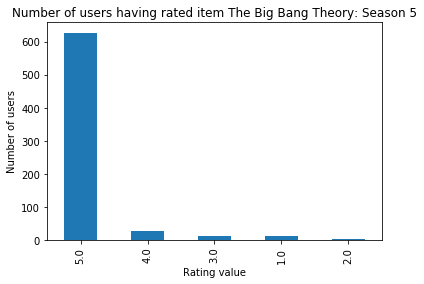

In [34]:
counter = Counter([r for (_, r) in trainset.ir[trainset.to_inner_iid('The Big Bang Theory: Season 5')]])
pd.DataFrame.from_dict(counter, orient='index').plot(kind='bar', legend=False)
plt.xlabel('Rating value')
plt.ylabel('Number of users')
plt.title('Number of users having rated item The Big Bang Theory: Season 5')
plt.show()

In [35]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
1384535,11446623,Star Trek (Single-Disc Edition),1.0,5.0,{'was_impossible': False},8,754,4.0
186652,28106048,Hill Climb Racing,1.0,5.0,{'was_impossible': False},3,6175,4.0
910679,25739238,Orphan Black Season 1,1.0,5.0,{'was_impossible': False},2,9745,4.0
885226,39343705,Crossy Road,1.0,5.0,{'was_impossible': False},13,20871,4.0
619124,17301239,Punch Quest,1.0,5.0,{'was_impossible': False},14,148,4.0
509767,43867407,Homeland: Season 2,1.0,5.0,{'was_impossible': False},1,351,4.0
58280,38800522,Outliers: The Story of Success,1.0,5.0,{'was_impossible': False},10,2642,4.0
1310646,34781971,Spider,1.0,5.0,{'was_impossible': False},5,5786,4.0
37109,42636978,Twenty-Eight and a Half Wishes (Rose Gardner M...,1.0,5.0,{'was_impossible': False},5,2339,4.0
1260161,6777962,Kingdom Rush,1.0,5.0,{'was_impossible': False},3,288,4.0


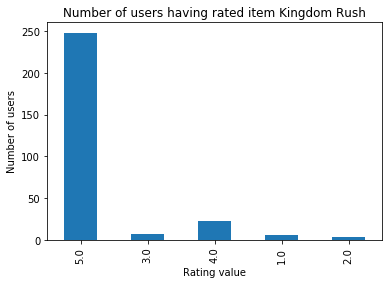

In [36]:
counter = Counter([r for (_, r) in trainset.ir[trainset.to_inner_iid('Kingdom Rush')]])
pd.DataFrame.from_dict(counter, orient='index').plot(kind='bar', legend=False)
plt.xlabel('Rating value')
plt.ylabel('Number of users')
plt.title('Number of users having rated item Kingdom Rush')
plt.show()

Below is the distribution of raw ratings vs. estimated ratings.  We can see that not all ratings are 1, 2, 3, 4 or 5 for estimated ratings but the distribution still follows a somewhat similar pattern.

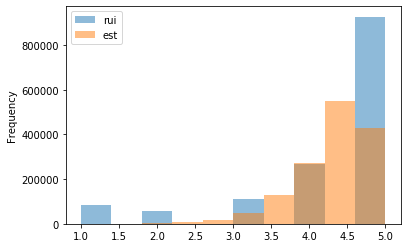

In [37]:
df[['rui', 'est']].plot(kind='hist', alpha=0.5)
plt.show()

<a id='recommending'></a>
<a id='above'></a>
<a href='Table of Contents'>Table of Contents</a>

------------
## Recommending Products to a Customer

We'll now use the surprise module to find the [top n](https://surprise.readthedocs.io/en/stable/FAQ.html) products for each customer that we observe.  We sample 10000 ratings because anything above kills our kernels or puts the notebook on a long hold for data processing and our computer may not be able to handle the computational strain.  It does limit our prediction power but we have to give a little to get a little.  To make predictions, we train our data and then predict for all pairs not in the training set.

<a id='building'></a>

### Building the Recommender
<a href='#Table of Contents'>Table of Contents</a>

In [38]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [39]:
# Take a random sample of ratings from dataset
np.random.seed(10)
apr_ = apr.iloc[np.random.choice(apr.index, size=10000, replace=False)]

# 1000 is 6.22 secs
# 10000 is 7 min 10 secs
# 50000 over 3 hours and still not finished
# All - kernels die

# First train an SVD algorithm on the amazon customer reviews dataset.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(apr_[['customer_id', 'product_title', 'star_rating']], reader)
trainset = data.build_full_trainset()
algo = SVD(n_factors=100, n_epochs=20, lr_all=0.007, reg_all=0.04, random_state=10)
algo.fit(trainset)

In [40]:
%%time

# Then predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)
print(accuracy.rmse(predictions))

RMSE: 0.2411
0.2411421362353418
CPU times: user 5min 23s, sys: 1min 10s, total: 6min 33s
Wall time: 7min 38s


Below we see the top 10 predictions for 5 customer ID's.  We'll turn the data into a dataframe.

In [41]:
# Find top n predictions
top_n = get_top_n(predictions, n=10)

# Print the recommended items for the first 5 users
counter = 0
for uid, user_ratings in top_n.items():
    if counter == 5:
        break
    print(uid, [iid for (iid, _) in user_ratings])
    counter += 1
    print('\n')

    
# Append recommended items for each user into a dictionary
top_items = {}
for uid, user_ratings in top_n.items():
    top_items[uid] = [iid for (iid, _) in user_ratings]

16344847 ['The Hunger Games (Hunger Games Trilogy, Book 1)', 'Downton Abbey Season 3', 'John Adams Season 1', 'Me Before You: A Novel', 'Band of Brothers Season 1', 'Suits Season 1', 'TuneIn Radio', 'Downton Abbey Season 5', 'Defending Jacob: A Novel', "Five Nights at Freddy's 2"]


30678701 ['Downton Abbey Season 3', 'The Pacific Season 1', 'The Hunger Games (Hunger Games Trilogy, Book 1)', 'Lone Survivor: The Eyewitness Account of Operation Redwing and the Lost Heroes of SEAL Team 10', 'Downton Abbey Season 5', 'Geometry Dash Lite', 'Wonder', "Five Nights at Freddy's", 'Sherlock Season 2', 'Firefly Season 1']


16465135 ['Downton Abbey Season 3', 'Band of Brothers Season 1', 'Crossy Road', 'The Hunger Games (Hunger Games Trilogy, Book 1)', 'The Room (Kindle Tablet Edition)', 'Downton Abbey Season 2', 'The Third Wheel (Diary of a Wimpy Kid, Book 7)', 'Amazon Underground', 'Me Before You: A Novel', 'John Adams Season 1']


45438862 ['Wonder', 'Hopeless', 'The Pacific Season 1', 'Downto

Below is a dataframe of our top 10 ratings for each customer ID, along with the customer's predicted ratings for the product.

In [42]:
recommended_w_ratings = pd.DataFrame.from_dict(top_n, orient='index')
recommended_w_ratings.head()

,0,1,2,3,4,5,6,7,8,9
16344847,"(The Hunger Games (Hunger Games Trilogy, Book ...","(Downton Abbey Season 3, 4.900347609925889)","(John Adams Season 1, 4.845003612820365)","(Me Before You: A Novel, 4.81854353869497)","(Band of Brothers Season 1, 4.7887700179517205)","(Suits Season 1, 4.778014007974196)","(TuneIn Radio, 4.766482839032318)","(Downton Abbey Season 5, 4.763049030886263)","(Defending Jacob: A Novel, 4.759979464784856)","(Five Nights at Freddy's 2, 4.757093535280311)"
30678701,"(Downton Abbey Season 3, 4.802539376502293)","(The Pacific Season 1, 4.72619072474924)","(The Hunger Games (Hunger Games Trilogy, Book ...",(Lone Survivor: The Eyewitness Account of Oper...,"(Downton Abbey Season 5, 4.687908580319665)","(Geometry Dash Lite, 4.664596452989186)","(Wonder, 4.658355071447615)","(Five Nights at Freddy's, 4.657501910135011)","(Sherlock Season 2, 4.649053538219418)","(Firefly Season 1, 4.642133538063709)"
16465135,"(Downton Abbey Season 3, 4.922477036291557)","(Band of Brothers Season 1, 4.872192006810055)","(Crossy Road, 4.835400370890903)","(The Hunger Games (Hunger Games Trilogy, Book ...","(The Room (Kindle Tablet Edition), 4.806700331...","(Downton Abbey Season 2, 4.806088614280652)","(The Third Wheel (Diary of a Wimpy Kid, Book 7...","(Amazon Underground, 4.78802571099864)","(Me Before You: A Novel, 4.783783390925335)","(John Adams Season 1, 4.783653341798226)"
45438862,"(Wonder, 4.992777341756024)","(Hopeless, 4.98681001560101)","(The Pacific Season 1, 4.966017198459856)","(Downton Abbey Season 3, 4.965416747581851)","(Crossy Road, 4.958280391767791)","(Me Before You: A Novel, 4.950539933579914)","(Firefly Season 1, 4.939410129966117)",(Lone Survivor: The Eyewitness Account of Oper...,"(Downton Abbey Season 4, 4.924693724003722)","(The Third Wheel (Diary of a Wimpy Kid, Book 7..."
35081900,"(Downton Abbey Season 3, 5)","(Crossy Road, 4.957932083457072)","(Me Before You: A Novel, 4.9098126796462065)","(Downton Abbey Season 5, 4.893141600858727)","(Five Nights at Freddy's, 4.869514455666185)",(A Dance with Dragons (A Song of Ice and Fire)...,"(Band of Brothers Season 1, 4.860383348292796)","(Evernote - stay organized., 4.855134108128775)","(John Adams Season 1, 4.843768425027998)","(My Horse, 4.836574726031152)"


Below is a dataframe of our top 10 ratings for each customer ID without predicted ratings for easier visualization.

In [43]:
recommended = pd.DataFrame.from_dict(top_items, orient='index')
recommended.head()

,0,1,2,3,4,5,6,7,8,9
16344847,"The Hunger Games (Hunger Games Trilogy, Book 1)",Downton Abbey Season 3,John Adams Season 1,Me Before You: A Novel,Band of Brothers Season 1,Suits Season 1,TuneIn Radio,Downton Abbey Season 5,Defending Jacob: A Novel,Five Nights at Freddy's 2
30678701,Downton Abbey Season 3,The Pacific Season 1,"The Hunger Games (Hunger Games Trilogy, Book 1)",Lone Survivor: The Eyewitness Account of Opera...,Downton Abbey Season 5,Geometry Dash Lite,Wonder,Five Nights at Freddy's,Sherlock Season 2,Firefly Season 1
16465135,Downton Abbey Season 3,Band of Brothers Season 1,Crossy Road,"The Hunger Games (Hunger Games Trilogy, Book 1)",The Room (Kindle Tablet Edition),Downton Abbey Season 2,"The Third Wheel (Diary of a Wimpy Kid, Book 7)",Amazon Underground,Me Before You: A Novel,John Adams Season 1
45438862,Wonder,Hopeless,The Pacific Season 1,Downton Abbey Season 3,Crossy Road,Me Before You: A Novel,Firefly Season 1,Lone Survivor: The Eyewitness Account of Opera...,Downton Abbey Season 4,"The Third Wheel (Diary of a Wimpy Kid, Book 7)"
35081900,Downton Abbey Season 3,Crossy Road,Me Before You: A Novel,Downton Abbey Season 5,Five Nights at Freddy's,A Dance with Dragons (A Song of Ice and Fire),Band of Brothers Season 1,Evernote - stay organized.,John Adams Season 1,My Horse


<a id='testing2'></a>
<a id='above2'></a>
<a href='#Table of Contents'>Table of Contents</a>

### Testing Product Recommendations for Customers

We test how it would look to have the top 10 products recommended with and without the predicted ratings attached.  We find that without the ratings attached makes the recommender easier to read.

We first look at a customer ID in order to see how many previous ratings the customer had and then see how the recommendations are affected by each type of customer.

In [44]:
def products_recommended(user):
    print('The top 10 product recommendations for user {} is:'.format(user))
    return recommended.loc[user]

def products_recommended_w_rating(user):
    number = 0
    print('The top 10 product recommendations with estimated ratings for user {} is:'.format(user))
    for rating in recommended_w_ratings.loc[user]:
        print(number,' ', rating[0], ' : ', rating[1])
        number += 1

<a id='test_1'></a>
<a href='#Table of Contents'>Table of Contents</a>

### Test 1
Several previous ratings + with or without estimated ratings attached.

In [45]:
apr[apr.customer_id == 30678701][
    ['customer_id', 'product_id', 'product_title', 'product_category', 
     'star_rating', 'review_headline', 'purchased_counts']
]

,customer_id,product_id,product_title,product_category,star_rating,review_headline,purchased_counts
3135341,30678701,B00000I5Y6,The Best of Kansas,Music,4.0,onward to Kansas,178
3135342,30678701,B001KVZ6F2,Gran Torino (Widescreen Edition),Video DVD,5.0,gran? how about grand!,340
3135343,30678701,B00BI5IXL4,Les Miserables (2012),Digital Video Download,3.0,a musical adventure,340
3135344,30678701,B000063DIH,Fear Of The Dark [Enhanced],Music,3.0,"gladly roam through this darkness, since it's ...",104
3135345,30678701,B000PTYP5C,Systematic Chaos,Music,3.0,I don't feel like dreaming to this stuff,117
...,...,...,...,...,...,...,...
3135761,30678701,0780628551,The Astronaut's Wife,Video DVD,2.0,could have been so much better,140
3135762,30678701,B00004RFFI,Twister,Video DVD,5.0,watch out for that tornado!,205
3135763,30678701,B00H57OXSG,Blue Jasmine,Digital Video Download,1.0,I'm feeling blue too,137
3135764,30678701,B000HEWEJO,It's a Wonderful Life (60th Anniversary Edition),Video DVD,5.0,a classic,720


In [46]:
products_recommended_w_rating(30678701)

The top 10 product recommendations with estimated ratings for user 30678701 is:
0   Downton Abbey Season 3  :  4.802539376502293
1   The Pacific Season 1  :  4.72619072474924
2   The Hunger Games (Hunger Games Trilogy, Book 1)  :  4.712462820594235
3   Lone Survivor: The Eyewitness Account of Operation Redwing and the Lost Heroes of SEAL Team 10  :  4.688086333425824
4   Downton Abbey Season 5  :  4.687908580319665
5   Geometry Dash Lite  :  4.664596452989186
6   Wonder  :  4.658355071447615
7   Five Nights at Freddy's  :  4.657501910135011
8   Sherlock Season 2  :  4.649053538219418
9   Firefly Season 1  :  4.642133538063709


In [47]:
products_recommended(30678701)

The top 10 product recommendations for user 30678701 is:


0                               Downton Abbey Season 3
1                                 The Pacific Season 1
2      The Hunger Games (Hunger Games Trilogy, Book 1)
3    Lone Survivor: The Eyewitness Account of Opera...
4                               Downton Abbey Season 5
5                                   Geometry Dash Lite
6                                               Wonder
7                              Five Nights at Freddy's
8                                    Sherlock Season 2
9                                     Firefly Season 1
Name: 30678701, dtype: object

<a id='test_2'></a>
<a href='#Table of Contents'>Table of Contents</a>

### Test 2
One previous rating.

In [48]:
apr[apr.customer_id == 9061660][
    ['customer_id', 'product_id', 'product_title', 'product_category', 
     'star_rating', 'review_headline', 'purchased_counts']
]

,customer_id,product_id,product_title,product_category,star_rating,review_headline,purchased_counts
611966,9061660,B004ADH1RI,The Goonies,Digital Video Download,5.0,Our most favorite family movie,838


In [49]:
products_recommended(9061660)

The top 10 product recommendations for user 9061660 is:


0                                               Wonder
1                               Me Before You: A Novel
2                                 The Pacific Season 1
3    Wheat Belly: Lose the Wheat, Lose the Weight, ...
4    Wool Omnibus Edition [Kindle in Motion] (Silo ...
5                                       Suits Season 2
6                            Band of Brothers Season 1
7                              Five Nights at Freddy's
8    Lone Survivor: The Eyewitness Account of Opera...
9                                    Sherlock Season 2
Name: 9061660, dtype: object

<a id='test_3'></a>
<a href='#Table of Contents'>Table of Contents</a>

### Test 3
Multiple previous ratings.

In [50]:
apr[apr.customer_id == 44894569][
    ['customer_id', 'product_id', 'product_title', 'product_category', 
     'star_rating', 'review_headline', 'purchased_counts']
]

,customer_id,product_id,product_title,product_category,star_rating,review_headline,purchased_counts
4518678,44894569,B00006RU5B,Audioslave,Music,4.0,Great CD - if one accepts that it is not RATM ...,969
4518679,44894569,B003OF3R0S,Nightmare,Music,5.0,A culmination of their previous four albums,236


In [51]:
products_recommended(44894569)

The top 10 product recommendations for user 44894569 is:


0                               Me Before You: A Novel
1                      Alarm Clock Xtreme Free + Timer
2                               Downton Abbey Season 3
3                                          Crossy Road
4                                               Frozen
5                                       Suits Season 1
6         Catching Fire (Hunger Games Trilogy, Book 2)
7                             Three Days of the Condor
8    The Life-Changing Magic of Tidying Up: The Jap...
9      The Hunger Games (Hunger Games Trilogy, Book 1)
Name: 44894569, dtype: object

<a id='evaluating'></a>
<a href='#Table of Contents'>Table of Contents</a>

------------
## Evaluating Product Recommendations for a Customer

In order to further measure if our predictions were a success we will evaluate [precision@k and recall@k](https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-compute-precision-k-and-recall-k) where:

<img src='https://raw.githubusercontent.com/dametreusv/amazon_hybrid_recommendation_system/master/visuals/precision_recall.png' width='750'>

An item is considered relevant if its true rating 𝑟𝑢𝑖 is greater than a given threshold. An item is considered recommended if its estimated rating 𝑟̂𝑢𝑖 is greater than the threshold, and if it is among the k highest estimated ratings.

In this evaluation, the threshold is set at 3.5 and we will first evaluate the precision@k and recall@k of our sampled predictions from the 10000 ratings <a href='#above'>(See Recommending Products to Customers</a> or <a href='#above2'>Testing Product Recommendations for Customers)</a>.  We will then evaluate the precision@k and recall@k of the full dataset of predictions, although we are unable to view our predictions because of the computational strain on this computer.

In [52]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

# Load sampled 10000 ratings dataset
data = Dataset.load_from_df(apr_[['customer_id', 'product_id', 'star_rating']], reader)
kf = KFold(n_splits=5)
algo = SVD(random_state=10)

print('Sampled 10000 Ratings \n')

number = 0
for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

    # Precision and recall can then be averaged over all users
    print('KFold Test #{}:'.format(number+1))
    print('Precision: {}'.format(sum(prec for prec in precisions.values()) / len(precisions)))
    print('Recall: {}'.format(sum(rec for rec in recalls.values()) / len(recalls)))
    print('\n')
    number += 1

Sampled 10000 Ratings 

KFold Test #1:
Precision: 0.8557114228456913
Recall: 0.9679358717434869


KFold Test #2:
Precision: 0.845
Recall: 0.9565


KFold Test #3:
Precision: 0.8223223223223223
Recall: 0.965965965965966


KFold Test #4:
Precision: 0.8449224612306153
Recall: 0.9599799899949975


KFold Test #5:
Precision: 0.8415915915915916
Recall: 0.9574574574574575




In [53]:
# Load full dataset
data = Dataset.load_from_df(apr[['customer_id', 'product_id', 'star_rating']], reader)
kf = KFold(n_splits=5)
algo = SVD(random_state=10)

print('Full Dataset \n')
number = 0
for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

    # Precision and recall can then be averaged over all users
    print('KFold Test #{}:'.format(number+1))
    print('Precision: {}'.format(sum(prec for prec in precisions.values()) / len(precisions)))
    print('Recall: {}'.format(sum(rec for rec in recalls.values()) / len(recalls)))
    print('\n')
    number += 1

Full Dataset 

KFold Test #1:
Precision: 0.9005001566088227
Recall: 0.8705995812909934


KFold Test #2:
Precision: 0.9008590029372812
Recall: 0.8690938265449699


KFold Test #3:
Precision: 0.9012094778520168
Recall: 0.8694729673910461


KFold Test #4:
Precision: 0.9009671511393442
Recall: 0.8694656881732762


KFold Test #5:
Precision: 0.9021510740757444
Recall: 0.8655278934356118




We can see that the sampled predictions have fairly precision scores and recall scores only a few points lower (3 points).  The full dataset of predictions have extremely high recall scores with precision scores much lower (11 points).  The sampled predictions are closer to consistency in recommending unseen items than the full predictions, but the full predictions are much more consistent in recommending seen items.

<a id='similar'></a>
<a href='#Table of Contents'>Table of Contents</a>

------------
## Recommending Similar Products

In recommending similar products we are using surprise to find the [k nearest neighbors of an item.](https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-get-the-k-nearest-neighbors-of-a-user-or-item)There’s a lot of boilerplate because of the conversions between product names and their raw/inner ids [(see this note)](https://surprise.readthedocs.io/en/stable/FAQ.html#raw-inner-note), but it all boils down to the use of [get_neighbors().](https://surprise.readthedocs.io/en/stable/algobase.html#surprise.prediction_algorithms.algo_base.AlgoBase.get_neighbors)  

In this recommendation system, we not only recommend the products similar to a given product, but we display what product category the recommended product belongs to.  Some are obvious, but for recommending products similar to 'Chromecast,' it's best to know what product categories the recommended products belong to.  It is also worth noting that we are able to map out the full dataset to predict similar items, rather than just a sample.

In [54]:
# Create simple id to map products
apr['id'] = apr.groupby('product_id').ngroup()

# Train the algortihm to compute the similarities between items
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(apr[['customer_id', 'id', 'star_rating']], reader)
trainset = data.build_full_trainset()
sim_options = {'name': 'pearson_baseline', 'user_based': False}
algo = KNNBaseline(sim_options=sim_options)
algo.fit(trainset)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [55]:
# Read the mappings raw id <-> product name
rid_to_name = dict(zip(apr.id, apr.product_title))
name_to_rid = dict(zip(apr.product_title, apr.id))

<a id='test__1'></a>
<a href='#Table of Contents'>Table of Contents</a>

### Test 1 - Minecraft

In [56]:
# Retrieve inner id of the product
product_raw_id = name_to_rid['Minecraft']
product_inner_id = algo.trainset.to_inner_iid(product_raw_id)

# Retrieve inner ids of the nearest neighbors of Toy Story.
product_neighbors = algo.get_neighbors(product_inner_id, k=10)

# Convert inner ids of the neighbors into names.
product_neighbors = (algo.trainset.to_raw_iid(inner_id)
                       for inner_id in product_neighbors)
product_neighbors = (rid_to_name[rid]
                       for rid in product_neighbors)

print('The 10 most similar products to Minecraft are:\n')
ranking = 0
for neighbor in product_neighbors:
    print('{}: {} - '.format(ranking, apr[apr['product_title'] == neighbor]['product_category'].iloc[0]), neighbor)
    ranking += 1

The 10 most similar products to Minecraft are:

0: Mobile Apps -  Bloons TD 5
1: Mobile Apps -  Angry Birds Epic RPG
2: Mobile Apps -  Twitter
3: Mobile Apps -  Farming Simulator 14
4: Mobile Apps -  Goat Simulator
5: Mobile Apps -  Head Soccer
6: Mobile Apps -  Asphalt 8: Airborne
7: Mobile Apps -  Hungry Shark Evolution
8: Mobile Apps -  The Dark Knight Rises (Kindle Tablet Edition)
9: Mobile Apps -  Dragon City


<a id='test__2'></a>
<a href='#Table of Contents'>Table of Contents</a>

### Test 2 - Candy Crush Saga

In [57]:
# Retrieve inner id of the product
product_raw_id = name_to_rid['Candy Crush Saga']
product_inner_id = algo.trainset.to_inner_iid(product_raw_id)

# Retrieve inner ids of the nearest neighbors of product.
product_neighbors = algo.get_neighbors(product_inner_id, k=10)

# Convert inner ids of the neighbors into names.
product_neighbors = (algo.trainset.to_raw_iid(inner_id)
                       for inner_id in product_neighbors)
product_neighbors = (rid_to_name[rid]
                       for rid in product_neighbors)

print('The 10 most similar products to Candy Crush Saga are:\n')
ranking = 0
for neighbor in product_neighbors:
    print('{}: {} - '.format(ranking, apr[apr['product_title'] == neighbor]['product_category'].iloc[0]), neighbor)
    ranking += 1

The 10 most similar products to Candy Crush Saga are:

0: Mobile Apps -  Frozen Free Fall
1: Mobile Apps -  Candy Crush Soda Saga
2: Mobile Apps -  Pet Rescue Saga
3: Mobile Apps -  Farm Heroes Saga
4: Mobile Apps -  Booty Quest – match 3 jewels and challenge friends!
5: Mobile Apps -  8 Ball Pool
6: Mobile Apps -  TuneIn Radio
7: Mobile Apps -  Diamond Dash
8: Mobile Apps -  The Secret Society® - Hidden Mystery
9: Mobile Apps -  CSI: Hidden Crimes


<a id='test__3'></a>
<a href='#Table of Contents'>Table of Contents</a>

### Test 3 - Game of Thrones Season 1

In [58]:
# Retrieve inner id of the product
product_raw_id = name_to_rid['Game of Thrones Season 1']
product_inner_id = algo.trainset.to_inner_iid(product_raw_id)

# Retrieve inner ids of the nearest neighbors of product.
product_neighbors = algo.get_neighbors(product_inner_id, k=10)

# Convert inner ids of the neighbors into names.
product_neighbors = (algo.trainset.to_raw_iid(inner_id)
                       for inner_id in product_neighbors)
product_neighbors = (rid_to_name[rid]
                       for rid in product_neighbors)

print('The 10 most similar products to Game of Thrones Season 1 are:\n')
ranking = 0
for neighbor in product_neighbors:
    print('{}: {} - '.format(ranking, apr[apr['product_title'] == neighbor]['product_category'].iloc[0]), neighbor)
    ranking += 1

The 10 most similar products to Game of Thrones Season 1 are:

0: Digital Video Download -  Game of Thrones Season 2
1: Digital Video Download -  Game of Thrones Season 2
2: Digital eBook Purchase -  A Clash of Kings (A Song of Ice and Fire, Book 2)
3: Digital Video Download -  Homeland Season 1
4: Digital Video Download -  Vikings Season 1
5: Digital eBook Purchase -  George R. R. Martin's A Game of Thrones 5-Book Boxed Set (Song of Ice and Fire Series): A Game of Thrones, A Clash of Kings, A Storm of Swords, A Feast for Crows, and A Dance with Dragons
6: Digital Video Download -  Brave
7: Digital Video Download -  Once Upon a Time Season 2
8: Digital Video Download -  The Walking Dead, Season 1
9: Digital Video Download -  Guardians of the Galaxy (Plus Bonus Features)


<a id='test__4'></a>
<a href='#Table of Contents'>Table of Contents</a>

### Test 4 - Ted (Unrated)

In [59]:
# Retrieve inner id of the product
product_raw_id = name_to_rid['Ted (Unrated)']
product_inner_id = algo.trainset.to_inner_iid(product_raw_id)

# Retrieve inner ids of the nearest neighbors of product.
product_neighbors = algo.get_neighbors(product_inner_id, k=10)

# Convert inner ids of the neighbors into names.
product_neighbors = (algo.trainset.to_raw_iid(inner_id)
                       for inner_id in product_neighbors)
product_neighbors = (rid_to_name[rid]
                       for rid in product_neighbors)

print('The 10 most similar products to Ted (Unrated) are:\n')
ranking = 0
for neighbor in product_neighbors:
    print('{}: {} - '.format(ranking, apr[apr['product_title'] == neighbor]['product_category'].iloc[0]), neighbor)
    ranking += 1

The 10 most similar products to Ted (Unrated) are:

0: Digital Video Download -  The Dark Knight Rises
1: Video DVD -  Looper
2: Digital Video Download -  Noah
3: Digital Video Download -  The Hunger Games: Catching Fire
4: Digital Video Download -  Hope Springs
5: Digital Video Download -  Gravity
6: Digital Video Download -  The Walking Dead, Season 3
7: Home Entertainment -  Google Chromecast HDMI Streaming Media Player
8: Digital Video Download -  Despicable Me
9: Digital Video Download -  Godzilla (2014)


<a id='test__5'></a>
<a href='#Table of Contents'>Table of Contents</a>

### Test 5 - Google Chromecast HDMI Streaming Media Player

In [60]:
# Retrieve inner id of the product
product_raw_id = name_to_rid['Google Chromecast HDMI Streaming Media Player']
product_inner_id = algo.trainset.to_inner_iid(product_raw_id)

# Retrieve inner ids of the nearest neighbors of product.
product_neighbors = algo.get_neighbors(product_inner_id, k=10)

# Convert inner ids of the neighbors into names.
product_neighbors = (algo.trainset.to_raw_iid(inner_id)
                       for inner_id in product_neighbors)
product_neighbors = (rid_to_name[rid]
                       for rid in product_neighbors)

print('The 10 most similar products to Google Chromecast HDMI Streaming Media Player are:\n')
ranking = 0
for neighbor in product_neighbors:
    print('{}: {} - '.format(ranking, apr[apr['product_title'] == neighbor]['product_category'].iloc[0]), neighbor)
    ranking += 1

The 10 most similar products to Google Chromecast HDMI Streaming Media Player are:

0: Mobile Apps -  Twitter
1: Mobile Apps -  TubeMate YouTube Downloader
2: Video DVD -  The Dark Knight Trilogy (Batman Begins / The Dark Knight / The Dark Knight Rises) [Blu-ray]
3: Video DVD -  The Hunger Games: Catching Fire [Blu-ray + DVD + Digital HD]
4: Electronics -  FiiO E6 Portable Audio Headphone Amplifier
5: Mobile Apps -  Adobe Acrobat Reader- PDF Reader and more
6: PC -  SanDisk Ultra 16GB UHS-I/Class 10 Micro SDHC Memory Card With Adapter- SDSDQUAN-016G-G4A [Old Version]
7: Digital eBook Purchase -  11/22/63: A Novel
8: PC -  Thunderbolt to Gigabit Ethernet Adapter
9: Mobile Apps -  OfficeSuite Professional


<a id='test__6'></a>
<a href='#Table of Contents'>Table of Contents</a>

### Test 6 - Lego Ghostbusters Ecto-1 21108

In [61]:
# Retrieve inner id of the product
product_raw_id = name_to_rid['LEGO Ghostbusters Ecto-1 21108']
product_inner_id = algo.trainset.to_inner_iid(product_raw_id)

# Retrieve inner ids of the nearest neighbors of product.
product_neighbors = algo.get_neighbors(product_inner_id, k=10)

# Convert inner ids of the neighbors into names.
product_neighbors = (algo.trainset.to_raw_iid(inner_id)
                       for inner_id in product_neighbors)
product_neighbors = (rid_to_name[rid]
                       for rid in product_neighbors)

print('The 10 most similar products to LEGO Ghostbusters Ecto-1 21108 are:\n')
ranking = 0
for neighbor in product_neighbors:
    print('{}: {} - '.format(ranking, apr[apr['product_title'] == neighbor]['product_category'].iloc[0]), neighbor)
    ranking += 1

The 10 most similar products to LEGO Ghostbusters Ecto-1 21108 are:

0: Toys -  LEGO 10218 Creator Pet Shop
1: Toys -  LEGO Technic 9398 4 x 4 Crawler (Discontinued by manufacturer)
2: Video DVD -  Lego Movie, The (Blu-ray)
3: Video DVD -  Ghostbusters / Ghostbusters II (4K-Mastered + Included Digibook) [Blu-ray]
4: Video DVD -  The LEGO Movie (DVD) Special Edition
5: Mobile Apps -  Minecraft
6: Home Entertainment -  Google Chromecast HDMI Streaming Media Player
7: Mobile Apps -  Amazon Underground
8: Video DVD -  Frozen [Blu-ray]
9: Toys -  LEGO Movie 70809 Lord Business' Evil Lair


<a id='conclusion'></a>
<a href='#Table of Contents'>Table of Contents</a>

------------
## Conclusion

Unlike content based filtering, which suggest only similar products or domain specific products, collaborative filtering recommendation systems allows users to find similar products and jump (or switch) to other categories of products based on similarities with other users and products.  In this case, we explored 3 different ways to use collaborative based filtering.

1. The first method suggests products that other users like to a specific user based on their rating of a specific product.  Essentially, it finds users that rated a product similar to the specific user and returns the top products the other users liked.  This method was used as an introduction to recommendation systems with a simple, built from scratch, recommender that did not incorporate actual training of models or prediction methods.


2. The second method predicts what products a user may like based on past rating history and the rating history of other users.  This method is not specific to the rating of one product like the first method.  It is a ratings based method that predicts the expected ratings a user would give a product and ranks the highest expected rated products for that user.  Unfortunately this method had to use a sample of the full dataset to train.


3. The third method predicts products similar to a specific product by finding the nearest neighbors to that product.  This method is good for users who may want to purchase products as bundles.  It is not ratings or user based as the previous two methods are.

<a id='potential'></a>
<a href='#Table of Contents'>Table of Contents</a>

------------
## Potential Future Work

We feel that our limited time and computational power prevented us from making the best predictions in selecting and tuning our model as well as making product predictions for specific customers.  In the future, we would like to work on training the complete dataset instead of a very small percentage (10% and less).